In [2]:
# Imports
import pandas as pd
import numpy as np
import tensorflow as tf

from sklearn.model_selection import train_test_split


2023-02-28 20:18:19.146524: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-28 20:18:19.538127: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-28 20:18:19.538152: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-28 20:18:20.634331: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [3]:
df = pd.read_csv('./data/processed_data.csv')
df.shape


(18471, 69)

In [1]:
# Final labels
labels = ['patientState_good', 'patientState_caution', 'patientState_danger']
# Section labels
section_labels = {
    'fever': ['feverState_good', 'feverState_caution', 'feverState_danger'],
    'medication': ['medicationState_good', 'medicationState_caution', 'medicationState_danger'],
    'hydration': ['hydrationState_good', 'hydrationState_caution', 'hydrationState_danger'],
    'respiration': ['respirationState_good', 'respirationState_caution', 'respirationState_danger'],
    'skin': ['skinState_good', 'skinState_caution', 'skinState_danger'],
    'pulse': ['pulseState_good', 'pulseState_caution', 'pulseState_danger'],
    'general': ['generalState_good', 'generalState_caution', 'generalState_danger'],
}

section_features = {
    'fever': ['ageInMonths', 'temperature', 'feverDuration'],
    'medication': [
        'antibiotics',
        'antibioticsHowMany',
        'antibioticsHowMuch',
        'antipyretic',
        'antipyreticHowMany',
        'antipyreticHowMuch'],
    'hydration': [
        'crying',
        'diarrhea',
        'drinking',
        'lastUrination',
        'skinTurgor',
        'tearsWhenCrying',
        'tongue',
        'vomit-01-No','vomit-02-Slight','vomit-03-Frequent','vomit-04-Yellow','vomit-05-5<hours'],
    'respiration': [
        'dyspnea',
        'respiratoryRate',
        'wheezing',
        'ageInMonths'],
    'skin': ['glassTest', 'rash', 'skinColor'],
    'pulse': ['pulse', 'ageInMonths'],
    'general': [
        'awareness-01-Normal','awareness-02-SleepyOddOrFeverishNightmares','awareness-03-NoReactionsNoAwareness',
        'bulgingFontanelleMax18MOld',
        'exoticTrip',
        'lastTimeEating',
        'pain-01-No','pain-02-FeelingBad','pain-03-Headache','pain-04-SwollenPainful','pain-05-StrongBellyacheAche',
        'painfulUrination',
        'seizure',
        'smellyUrine',
        'vaccinationIn14days',
        'vaccinationHowManyHoursAgo',
        'wryNeck'],
}
# Section labels in an array flattened
section_labels_arr = [item for val in section_labels.values() for item in val]
# All labels
all_labels = [*labels, *section_labels_arr]

In [4]:
# Separating to testing and training

# Prepare the data: You should split your data into training and test sets.
# The training set will be used to train the model and the test set will be used
# to evaluate the model's performance.
def split(dataset, ground_truth, test_size=0.2, val_size=0.2):
    _x, x_test, _y, y_test = train_test_split(
        dataset.to_numpy(),
        ground_truth.to_numpy(),
        test_size=test_size,
        random_state=42
    )
    x_train, x_val, y_train, y_val = train_test_split(
        _x,
        _y,
        test_size=val_size / 0.8,
        random_state=42
    )
    return x_train, np.argmax(y_train, axis=1), x_val, np.argmax(y_val, axis=1), x_test, np.argmax(y_test, axis=1)


In [5]:
import tensorflow_decision_forests as tfdf

In [ ]:

models = {}

for key in section_features.keys():
    x_train, y_train, x_val, y_val, x_test, y_test = split(
        df[section_features[key]],
        df[section_labels[key]]
    )

    model = tfdf.keras.RandomForestModel()
    model.fit(x=x_train, y=y_train, validation_data=(x_val, y_val), verbose=0)

    loss = model.evaluate(x=x_test, y=y_test)

    print('>>>')
    print("Model", key)
    print("loss: %.2f" % loss)

    models[key] = model


In [54]:
for key, model in models.items():
    model.save('model/'+key)


INFO:tensorflow:Assets written to: model/fever/assets


INFO:tensorflow:Assets written to: model/fever/assets


INFO:tensorflow:Assets written to: model/medication/assets


INFO:tensorflow:Assets written to: model/medication/assets


INFO:tensorflow:Assets written to: model/hydration/assets


INFO:tensorflow:Assets written to: model/hydration/assets


INFO:tensorflow:Assets written to: model/respiration/assets


INFO:tensorflow:Assets written to: model/respiration/assets


INFO:tensorflow:Assets written to: model/skin/assets


INFO:tensorflow:Assets written to: model/skin/assets


INFO:tensorflow:Assets written to: model/pulse/assets


INFO:tensorflow:Assets written to: model/pulse/assets


INFO:tensorflow:Assets written to: model/general/assets


INFO:tensorflow:Assets written to: model/general/assets


In [41]:
plot = tfdf.model_plotter.plot_model(model, tree_idx=0, max_depth=3)
len(plot)


16754

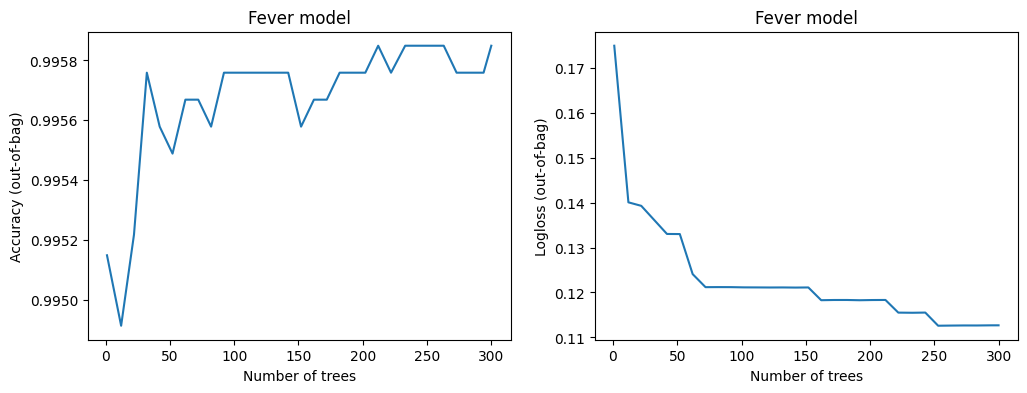

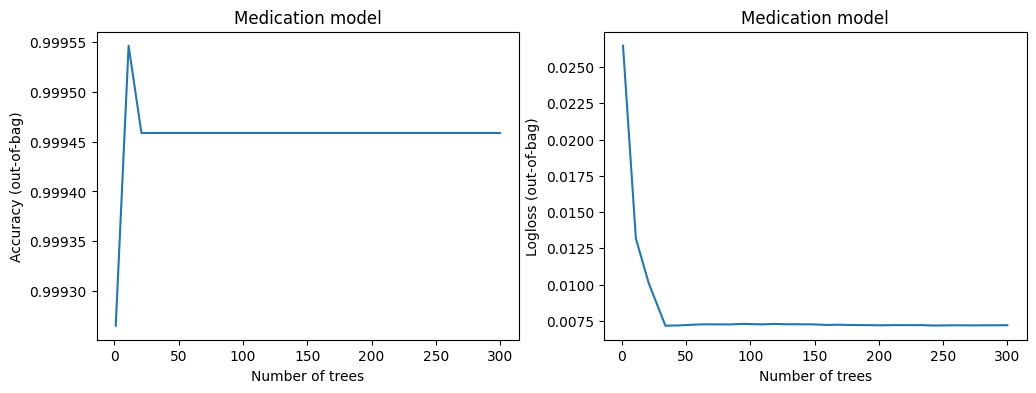

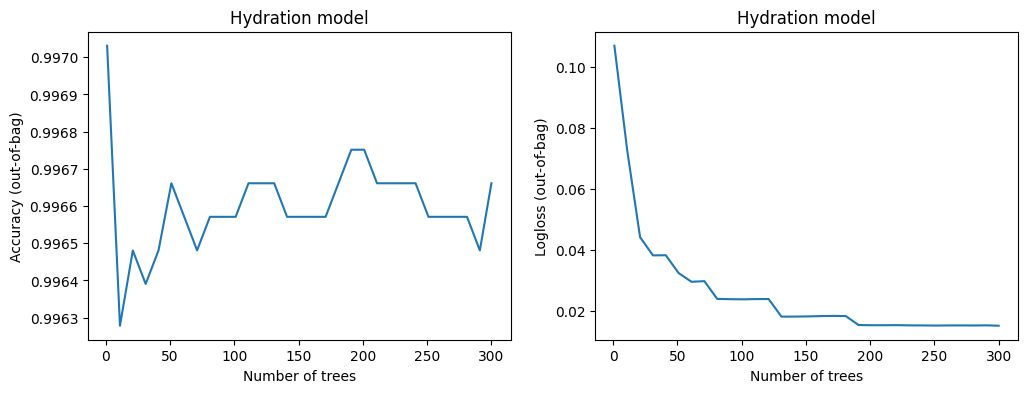

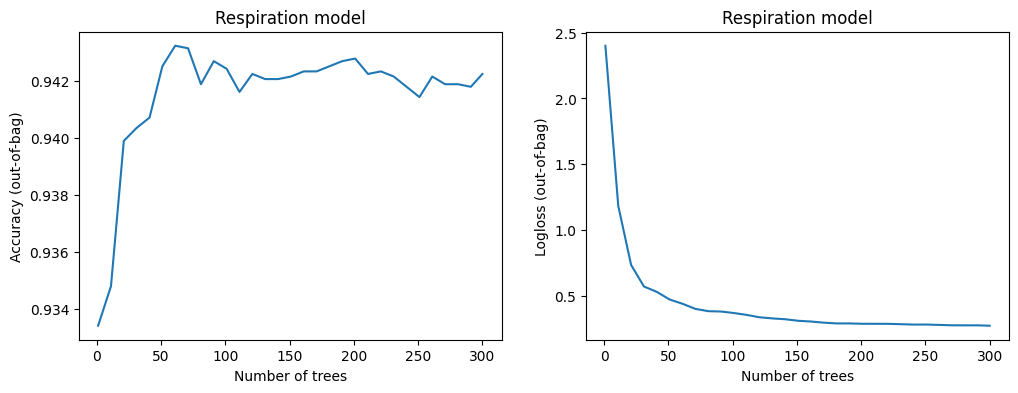

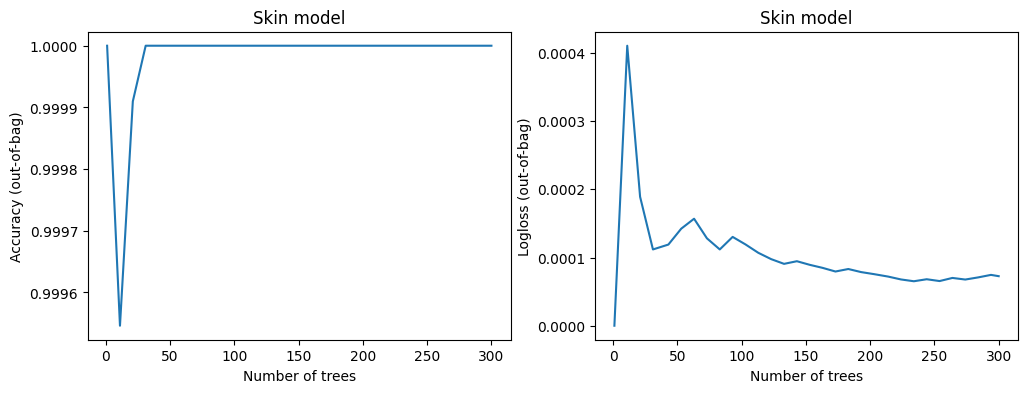

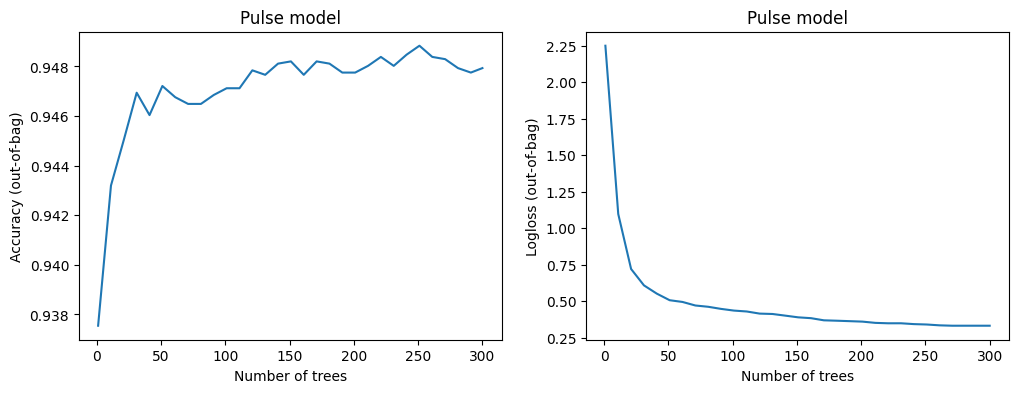

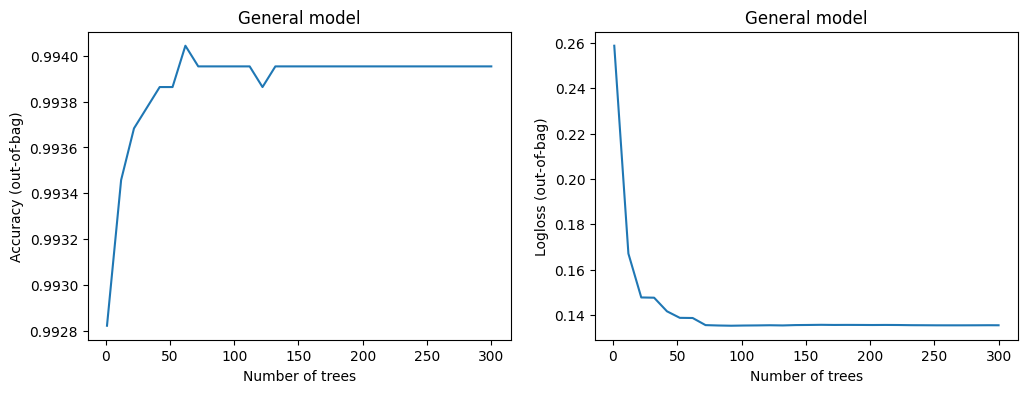

In [60]:
import matplotlib.pyplot as plt

for key, model in models.items():
    logs = model.make_inspector().training_logs()

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.title(key.capitalize() + ' model')
    plt.plot([log.num_trees for log in logs], [
            log.evaluation.accuracy for log in logs])
    plt.xlabel("Number of trees")
    plt.ylabel("Accuracy (out-of-bag)")

    plt.subplot(1, 2, 2)
    plt.title(key.capitalize() + ' model')
    plt.plot([log.num_trees for log in logs], [
            log.evaluation.loss for log in logs])
    plt.xlabel("Number of trees")
    plt.ylabel("Logloss (out-of-bag)")

    plt.show()


In [8]:
# Using decision forest for the whole dataset
x_train, y_train, x_val, y_val, x_test, y_test = split(
    df.drop(columns=all_labels),
    df[labels]
)
print("X shape:", x_train.shape)
model = tfdf.keras.RandomForestModel()
model.fit(x=x_train, y=y_train, validation_data=(x_val, y_val), verbose=0)

loss = model.evaluate(x=x_test, y=y_test)

print('>>>')
print("loss: %.2f" % loss)

X shape: (11082, 45)
Use /tmp/tmpwwqxxc5t as temporary training directory
Num validation examples: tf.Tensor(3694, shape=(), dtype=int32)


[INFO 2023-02-28T20:27:03.197521994+01:00 kernel.cc:1214] Loading model from path /tmp/tmpwwqxxc5t/model/ with prefix d5b223a9dc3a4b0a
[INFO 2023-02-28T20:27:03.568045891+01:00 decision_forest.cc:661] Model loaded with 300 root(s), 143498 node(s), and 44 input feature(s).
[INFO 2023-02-28T20:27:03.568077355+01:00 abstract_model.cc:1311] Engine "RandomForestGeneric" built
[INFO 2023-02-28T20:27:03.568097839+01:00 kernel.cc:1046] Use fast generic engine


116/116 [==============================] - 0s 3ms/step - loss: 0.0000e+00
>>>
loss: 0.00


In [9]:
model.save('model/all')

INFO:tensorflow:Assets written to: model/all/assets


INFO:tensorflow:Assets written to: model/all/assets
